# Explore here

2018-10-19
       neighbourhood_group_Manhattan  neighbourhood_group_Manhattan
61                               0.0                            NaN
85                               0.0                            0.0
103                              1.0                            NaN
121                              1.0                            NaN
158                              0.0                            NaN
...                              ...                            ...
47703                            NaN                            NaN
47718                            NaN                            NaN
47722                            NaN                            NaN
48235                            NaN                            NaN
48799                            NaN                            NaN

[2278 rows x 2 columns]
['neighbourhood_group_Manhattan', 'neighbourhood_group_Bronx', 'neighbourhood_group_Staten Island', 'neighbourhood_group_Queens', 'neighbourhood_gro

KeyError: "None of [Index([('n', 'e', 'i', 'g', 'h', 'b', 'o', 'u', 'r', 'h', 'o', 'o', 'd', '_', 'g', 'r', 'o', 'u', 'p', '_', 'M', 'a', 'n', 'h', 'a', 't', 't', 'a', 'n'), ('n', 'e', 'i', 'g', 'h', 'b', 'o', 'u', 'r', 'h', 'o', 'o', 'd', '_', 'g', 'r', 'o', 'u', 'p', '_', 'M', 'a', 'n', 'h', 'a', 't', 't', 'a', 'n')], dtype='object')] are in the [index]"

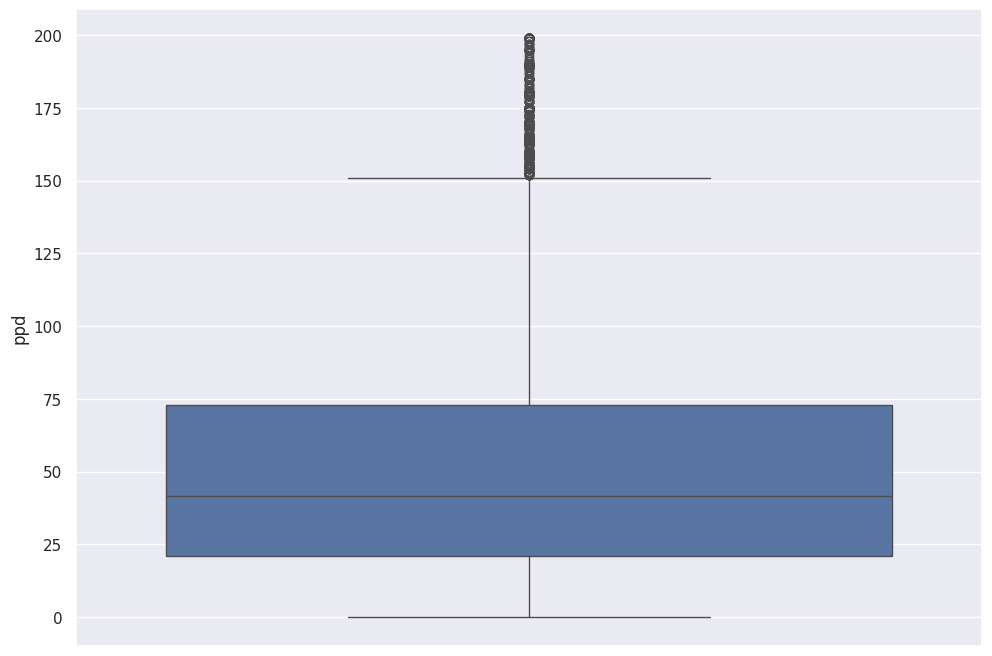

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, SelectKBest
from statistics import stdev
import datetime as dt


def date_converter(str_date):
    if not pd.isna(str_date):
        diff = dt.datetime.today() - dt.datetime.strptime(str_date, '%Y-%m-%d')
        return diff.days
    else:
        return str_date


train_data = pd.read_csv(
    'https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv')
train_data['review_days'] = train_data['last_review'].apply(date_converter)
print(len(train_data))
train_data.drop(['name', 'host_name', 'host_id', 'last_review'], axis=1, inplace=True)
print(len(train_data))
train_data.dropna(axis=0, inplace=True)
print(len(train_data))
train_data['ppd'] = train_data['price'] / train_data['minimum_nights']
fig, axs = plt.subplots(3, 1, figsize=(5, 7))
# sns.boxplot(ax=axs[0], data=train_data['ppd'])
# sns.boxplot(ax=axs[1], data=train_data['price'])
# axs[0].set_ylim(-100, 400)
# axs[1].set_ylim(-100, 400)
# plt.show()
sns.heatmap(train_data[['review_days', "latitude", "longitude", "price", 'ppd', "minimum_nights", "number_of_reviews",
                        'reviews_per_month', 'availability_365', 'calculated_host_listings_count']].corr(), annot=True,
            fmt=".2f", ax=axs[0])
cat_calls = train_data.select_dtypes(include=['object']).columns.to_list()
one_hot = OneHotEncoder(sparse_output=False)
one_hot_train = one_hot.fit_transform(train_data[cat_calls])
cols = one_hot.get_feature_names_out(cat_calls)
code_train = pd.concat([train_data, pd.DataFrame(one_hot_train, columns=cols)], axis=1)
code_train.drop(cat_calls, axis=1, inplace=True)
code_mess = code_train.loc[code_train['price'] > 350]
code_mess += code_train.loc[code_train['ppd'] > 200]
code_train = code_train.loc[code_train['price'] < 350]
code_train = code_train.loc[code_train['ppd'] < 200]
code_train.dropna(axis=0, inplace=True)
sns.heatmap(code_train[['review_days', "latitude", "longitude", "price", 'ppd', "minimum_nights", "number_of_reviews",
                        'reviews_per_month', 'availability_365', 'calculated_host_listings_count']].corr(), annot=True,
            fmt=".2f", ax=axs[1])
sns.heatmap(code_mess[['review_days', "latitude", "longitude", "price", 'ppd', "minimum_nights", "number_of_reviews",
                       'reviews_per_month', 'availability_365', 'calculated_host_listings_count']].corr(), annot=True,
            fmt=".2f", ax=axs[2])
# sns.boxplot(ax=ax, data=code_train['ppd'])
# ax.set_ylim(1, 1000)
supradict = {}
codes = [code_train, code_mess]
for h in range(len([code_train, code_mess])):
    supradict[h] = {}
    for i in cat_calls:
        subdict = {i: {}}
        group = [j for j in codes[h].columns if j.startswith(i)]
        group = list(set(group))
        for j in group:
            dic = subdict[i][j] = {'group': [], 'mean': None, 'range': None, 'dev': None, }
            # print(codes[h].loc[codes[h][j] > 0, ['ppd']]['ppd'])
            dic['group'] = [k for k in codes[h].loc[codes[h][j] > 0, ['ppd']]['ppd'] if not pd.isna(k)]
            if len(dic['group']) > 1:
                for k in dic['group']:
                    if type(k) == str:
                        dic['group'].pop(k)
                dic['mean'] = sum(dic['group']) / len(dic['group'])
                dic['range'] = max(dic['group']) - min(dic['group'])
                dic['dev'] = stdev(dic['group'])
        supradict[h][i] = subdict[i]
std = {}
avg = {}
ran = {}
lng = {}
for i in supradict.keys():
    std[i] = {}
    avg[i] = {}
    ran[i] = {}
    lng[i] = {}
    for j in supradict[i].keys():
        std[i][j] = []
        avg[i][j] = []
        ran[i][j] = []
        lng[i][j] = []
        for k in supradict[i][j].keys():
            for l in supradict[i][j][k].keys():
                if supradict[i][j][k][l] is not None:
                    if l == 'mean':
                        avg[i][j].append(supradict[i][j][k][l])
                    elif l == 'range':
                        ran[i][j].append(supradict[i][j][k][l])
                    elif l == 'dev':
                        std[i][j].append(supradict[i][j][k][l])
                        lng[i][j].append(len(supradict[i][j][k]['group']))
for i in std.keys():
    for j in std[i].keys():
        print(i, j, 'std', min(std[i][j]), max(std[i][j]), sum(std[i][j]) / len(std[i][j]))
for i in avg.keys():
    for j in avg[i].keys():
        print(i, j, 'avg', min(avg[i][j]), max(avg[i][j]), sum(avg[i][j]) / len(avg[i][j]))
for i in ran.keys():
    for j in ran[i].keys():
        print(i, j, 'ran', min(ran[i][j]), max(ran[i][j]), sum(ran[i][j]) / len(ran[i][j]))
for i in lng.keys():
    for j in lng[i].keys():
        print(i, j, 'lng', min(lng[i][j]), max(lng[i][j]), sum(lng[i][j]) / len(lng[i][j]))
plt.show()

code_train.drop(['minimum_nights', 'availability_365', 'review_days', 'id'], axis=1, inplace=True)
X = code_train.drop(['price', 'ppd'], axis=1)
Y1 = code_train['price']
Y2 = code_train['ppd']

X_train, X_test, Y1_train, Y1_test = train_test_split(X, Y1, test_size=0.2, random_state=42)
_, __, Y2_train, Y2_test = train_test_split(X, Y2, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scal = scaler.transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, index=X_train.index, columns=X_train.columns)

X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, index=X_test.index, columns=X_test.columns)
